<a href="https://colab.research.google.com/github/devanshkasaudhan/Chemical-Reaction-Yield-Prediction/blob/main/USTPO_training_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torch
!pip install simpletransformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install rdkit
!git clone https://github.com/rxn4chemistry/rxn_yields.git
!git clone https://github.com/rxn4chemistry/rxnfp.git

import sklearn
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdChemReactions
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import zipfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 10.6 MB/s eta 0:00:00
Cloning into 'rxn_yields'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 500 (delta 55), reused 77 (delta 35), pack-reused 386
Receiving objects: 100% (500/500), 1.17 GiB | 28.80 MiB/s, done.
Resolving deltas: 100% (133/133), done.
Updating files: 100% (440/440), done.
Cloning into 'rxnfp'...
remote: Enumerating objects: 423, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 423 (delta 73), reused 85 (delta 37), pack-reused 290
Receiving objects: 100% (423/423), 330.20 MiB | 31.46 MiB/s, done.
Resolving deltas: 100% (177/177), done.
Updating files: 100% (173/173), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with zipfile.ZipFile('/content/drive/MyDrive/Major_Project/uspto_yields.zip', 'r') as zip_ref:
    zip_ref.extractall('rxn_yields')

df = pd.read_csv('/content/rxn_yields/uspto_yields/milligram_train_random_split.tsv', sep='\t')

Mounted at /content/drive


In [ ]:
df.head()

,Unnamed: 0,rxn,scaled_yield
0,applications_1745703,CC(C)(C)OC(=O)[C@H](CCS(C)(=O)=O)NC(=O)c1ccc(O...,0.331
1,grants_1403823,CCCCCCCCCCCCCCCCC(=O)OC(=O)CCCCCCCCCCCCCCCC.Nc...,0.988
2,applications_681789,COC(=O)[C@H](C(C)C)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl...,0.648
3,applications_1347491,CC(C)(C)OC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)O.CC(C)...,0.830
4,grants_893421,C1CN2CCN1CC2.CN(C(=O)Cl)c1ccccc1.CN(C)C=O.O.Oc...,0.653


In [ ]:
gram_df = pd.read_csv('/content/rxn_yields/uspto_yields/yields_above_200622.tsv', sep='\t', index_col=0)
gram_df['calc_yield'] = gram_df.calc_yield_above

milligram_df = pd.read_csv('/content/rxn_yields/uspto_yields/yields_below_200622.tsv', sep='\t', index_col=0)
milligram_df['calc_yield'] = milligram_df.calc_yield_below

<Axes: xlabel='Yields [%] - milligram scale'>

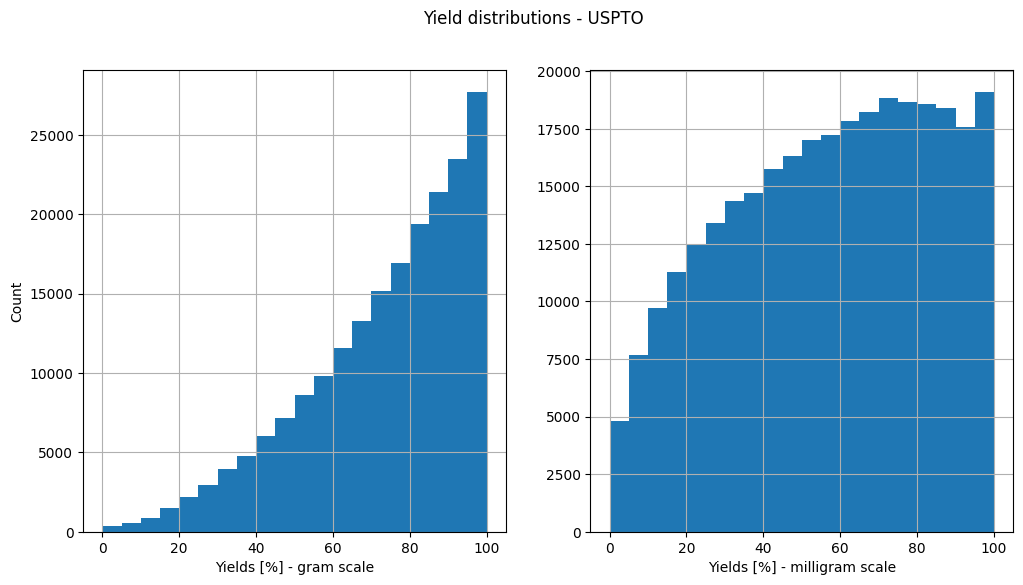

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Yield distributions - USPTO')
ax1.set_ylabel('Count')
ax1.set_xlabel('Yields [%] - gram scale')
gram_df.calc_yield.hist(bins=20, ax=ax1)
ax2.set_xlabel('Yields [%] - milligram scale')
milligram_df.calc_yield.hist(bins=20, ax=ax2)

In [ ]:
pd.concat([gram_df['calc_yield'].describe(),milligram_df['calc_yield'].describe()], axis=1)

,calc_yield,calc_yield
count,197619.000000,302040.000000
mean,73.232436,56.841559
std,20.942848,26.642160
min,0.000000,0.000000
25%,60.200000,35.500000
50%,78.000000,58.900000
75%,90.300000,79.500000
max,100.000000,100.000000


In [ ]:
milligram_df['rxn'] = milligram_df.tokenized_reactants_inputs.str.replace(' ', '') + '>>' + milligram_df.tokenized_products_inputs.str.replace(' ', '')
milligram_df['scaled_yield'] = milligram_df.calc_yield / 100
milligram_train_random_split_df = milligram_df[milligram_df.random_split=='train'][['rxn', 'scaled_yield']].sample(frac=1., random_state=42)
milligram_test_random_split_df = milligram_df[milligram_df.random_split=='test'][['rxn', 'scaled_yield']]
milligram_train_time_split_df = milligram_df[milligram_df.time_split=='train'][['rxn', 'scaled_yield']].sample(frac=1., random_state=42)
milligram_test_time_split_df = milligram_df[milligram_df.time_split=='test'][['rxn', 'scaled_yield']]

In [ ]:
milligram_train_random_split_df.head()

,rxn,scaled_yield
applications_1745703,CC(C)(C)OC(=O)[C@H](CCS(C)(=O)=O)NC(=O)c1ccc(O...,0.331
grants_1403823,CCCCCCCCCCCCCCCCC(=O)OC(=O)CCCCCCCCCCCCCCCC.Nc...,0.988
applications_681789,COC(=O)[C@H](C(C)C)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl...,0.648
applications_1347491,CC(C)(C)OC(=O)N[C@@H](Cc1c[nH]cn1)C(=O)O.CC(C)...,0.830
grants_893421,C1CN2CCN1CC2.CN(C(=O)Cl)c1ccccc1.CN(C)C=O.O.Oc...,0.653


In [ ]:
gram_df['rxn'] = gram_df.tokenized_reactants_inputs.str.replace(' ', '') + '>>' + gram_df.tokenized_products_inputs.str.replace(' ', '')
gram_df['scaled_yield'] = gram_df.calc_yield / 100
gram_train_random_split_df = gram_df[gram_df.random_split=='train'][['rxn', 'scaled_yield']].sample(frac=1., random_state=42)
gram_test_random_split_df = gram_df[gram_df.random_split=='test'][['rxn', 'scaled_yield']]
gram_train_time_split_df = gram_df[gram_df.time_split=='train'][['rxn', 'scaled_yield']].sample(frac=1., random_state=42)
gram_test_time_split_df = gram_df[gram_df.time_split=='test'][['rxn', 'scaled_yield']]

In [ ]:
milligram_df.head()

,tokenized_reactants_inputs,tokenized_products_inputs,products,has_fragments,products_largest_fragment,is_in_reactants,tokenized_largest_fragments_inputs,mass_norm_above,mass_norm_below,calc_yield_above,calc_yield_below,year,sources,random_split,time_split,calc_yield,rxn,scaled_yield
grants_19,C C O S ( = O ) ( = O ) O C C . C N ( C ) C = ...,C C n 1 c n c 2 n c c c c 2 1,CCn1cnc2ncccc21,False,CCn1cnc2ncccc21,False,C C n 1 c n c 2 n c c c c 2 1,NaN,0.40,NaN,64.8,2008,"['US08182718B2_0460', 'US20080105851A1_0414', ...",test,train,64.8,CCOS(=O)(=O)OCC.CN(C)C=O.[H-]~[Na+].c1cnc2[nH]...,0.648
grants_25,C N ( C ) C = O . C O S ( = O ) ( = O ) O C . ...,C n 1 c ( - c 2 n c 3 c c c c c 3 [nH] 2 ) n c...,Cn1c(-c2nc3ccccc3[nH]2)nc2ccccc21,False,Cn1c(-c2nc3ccccc3[nH]2)nc2ccccc21,False,C n 1 c ( - c 2 n c 3 c c c c c 3 [nH] 2 ) n c...,NaN,0.50,NaN,39.3,2008,"['US20080106781A1_0521', 'US09011734B2_0473', ...",train,train,39.3,CN(C)C=O.COS(=O)(=O)OC.[Na+]~[OH-].c1ccc2[nH]c...,0.393
grants_35,C N ( C ) C = O . C c 1 c c c 2 n c ( S ) [nH]...,C c 1 c c c 2 c ( c 1 ) n c 1 n 2 C C C S 1,Cc1ccc2c(c1)nc1n2CCCS1,False,Cc1ccc2c(c1)nc1n2CCCS1,False,C c 1 c c c 2 c ( c 1 ) n c 1 n 2 C C C S 1,NaN,0.63,NaN,25.3,2008,"['US20080105851A1_0437', 'US20080106781A1_0577...",train,train,25.3,CN(C)C=O.Cc1ccc2nc(S)[nH]c2c1.ICCCI.O=C([O-])[...,0.253
grants_43,C C C C [N+] ( C C C C ) ( C C C C ) C C C C ~...,c 1 c c n 2 c n c c 2 c 1,c1ccn2cncc2c1,False,c1ccn2cncc2c1,False,c 1 c c n 2 c n c c 2 c 1,NaN,0.36,NaN,16.5,2008,"['US09011734B2_0498', 'US08431045B2_0497', 'US...",train,train,16.5,CCCC[N+](CCCC)(CCCC)CCCC~[Br-].COCCOC.ClC(Cl)C...,0.165
grants_51,C C C I . C N ( C ) C = O . [K+] ~ [OH-] . c 1...,C C C N ( C c 1 c c c c n 1 ) C c 1 c c c c n 1,CCCN(Cc1ccccn1)Cc1ccccn1,False,CCCN(Cc1ccccn1)Cc1ccccn1,False,C C C N ( C c 1 c c c c n 1 ) C c 1 c c c c n 1,NaN,0.65,NaN,53.7,2008,"['US08431045B2_0508', 'US20080105851A1_0459', ...",train,train,53.7,CCCI.CN(C)C=O.[K+]~[OH-].c1ccc(CNCc2ccccn2)nc1...,0.537


In [ ]:
gram_df.head()

,tokenized_reactants_inputs,tokenized_products_inputs,products,has_fragments,products_largest_fragment,is_in_reactants,tokenized_largest_fragments_inputs,mass_norm_above,mass_norm_below,calc_yield_above,calc_yield_below,year,sources,random_split,time_split,calc_yield,rxn,scaled_yield
grants_0,C C ( C ) ( C ) O C ( = O ) O C ( = O ) O C ( ...,C C O C ( = O ) [C@@H] 1 C C C ( = O ) N 1 C (...,CCOC(=O)[C@@H]1CCC(=O)N1C(=O)OC(C)(C)C,False,CCOC(=O)[C@@H]1CCC(=O)N1C(=O)OC(C)(C)C,False,C C O C ( = O ) [C@@H] 1 C C C ( = O ) N 1 C (...,323.00,NaN,98.9,NaN,2002,"['USRE044186E1_0214', 'US20020019411A1_0203', ...",train,train,98.9,CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.CCOC(=O)[C@@H]1C...,0.989
grants_14,C N ( C ) C = O . Cl C c 1 c c c c c 1 . O = C...,c 1 c c c ( C n 2 c ( - c 3 c c c c n 3 ) n c ...,c1ccc(Cn2c(-c3ccccn3)nc3ccccc32)cc1,False,c1ccc(Cn2c(-c3ccccn3)nc3ccccc32)cc1,False,c 1 c c c ( C n 2 c ( - c 3 c c c c n 3 ) n c ...,2.40,NaN,82.1,NaN,2008,"['US09011734B2_0460', 'US20080105851A1_0409', ...",train,train,82.1,CN(C)C=O.ClCc1ccccc1.O=C([O-])[O-]~[K+]~[K+].c...,0.821
grants_21,C 1 C C O C 1 . C C O S ( = O ) ( = O ) O C C ...,C C n 1 c ( - c 2 c s c n 2 ) n c 2 c c c c c 2 1,CCn1c(-c2cscn2)nc2ccccc21,False,CCn1c(-c2cscn2)nc2ccccc21,False,C C n 1 c ( - c 2 c s c n 2 ) n c 2 c c c c c 2 1,3.70,NaN,64.9,NaN,2008,"['US08431045B2_0466', 'US20080105851A1_0416', ...",train,train,64.9,C1CCOC1.CCOS(=O)(=O)OCC.[Na+]~[OH-].c1ccc2[nH]...,0.649
grants_23,C S ( = O ) ( = O ) O . N c 1 c c c c c 1 N . ...,Br c 1 c c c c c 1 - c 1 n c 2 c c c c c 2 [nH] 1,Brc1ccccc1-c1nc2ccccc2[nH]1,False,Brc1ccccc1-c1nc2ccccc2[nH]1,False,Br c 1 c c c c c 1 - c 1 n c 2 c c c c c 2 [nH] 1,3.85,NaN,56.7,NaN,2008,"['US07525717B2_0578', 'US08018639B2_0585', 'US...",train,train,56.7,CS(=O)(=O)O.Nc1ccccc1N.O.O=C(O)c1ccccc1Br.O=C(...,0.567
grants_24,Br c 1 c c c c c 1 - c 1 n c 2 c c c c c 2 [nH...,C n 1 c ( - c 2 c c c c c 2 Br ) n c 2 c c c c...,Cn1c(-c2ccccc2Br)nc2ccccc21,False,Cn1c(-c2ccccc2Br)nc2ccccc21,False,C n 1 c ( - c 2 c c c c c 2 Br ) n c 2 c c c c...,2.90,NaN,83.6,NaN,2008,"['US07542196B2_0586', 'US08182718B2_0465', 'US...",test,train,83.6,Brc1ccccc1-c1nc2ccccc2[nH]1.C1CCOC1.COS(=O)(=O...,0.836


In [ ]:
from simpletransformers.config.model_args import ClassificationArgs
from simpletransformers.classification import ClassificationModel
from simpletransformers.losses.loss_utils import init_loss
from simpletransformers.classification.classification_model import (MODELS_WITHOUT_SLIDING_WINDOW_SUPPORT,
                                               MODELS_WITHOUT_CLASS_WEIGHTS_SUPPORT,
                                               MODELS_WITH_EXTRA_SEP_TOKEN,
                                               MODELS_WITH_ADD_PREFIX_SPACE)
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from typing import List
from transformers import BertConfig
import random
import re

In [ ]:
#@title SmilesTokenizer
class SmilesTokenizer(BertTokenizer):
    """
    Constructs a SmilesBertTokenizer.
    Adapted from https://github.com/huggingface/transformers
    and https://github.com/rxn4chemistry/rxnfp.

    Args:
        vocabulary_file: path to a token per line vocabulary file.
    """

    def __init__(
        self,
        vocab_file: str,
        unk_token: str = "[UNK]",
        sep_token: str = "[SEP]",
        pad_token: str = "[PAD]",
        cls_token: str = "[CLS]",
        mask_token: str = "[MASK]",
        do_lower_case=False,
        **kwargs,
    ) -> None:
        """Constructs an SmilesTokenizer.
        Args:
            vocabulary_file: vocabulary file containing tokens.
            unk_token: unknown token. Defaults to "[UNK]".
            sep_token: separator token. Defaults to "[SEP]".
            pad_token: pad token. Defaults to "[PAD]".
            cls_token: cls token. Defaults to "[CLS]".
            mask_token: mask token. Defaults to "[MASK]".
        """
        super().__init__(
            vocab_file=vocab_file,
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            do_lower_case=do_lower_case,
            **kwargs,
        )
        # define tokenization utilities
        self.tokenizer = RegexTokenizer()

    @property
    def vocab_list(self) -> List[str]:
        """List vocabulary tokens.
        Returns:
            a list of vocabulary tokens.
        """
        return list(self.vocab.keys())

    def _tokenize(self, text: str) -> List[str]:
        """Tokenize a text representing an enzymatic reaction with AA sequence information.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens.
        """
        return self.tokenizer.tokenize(text)

SMI_REGEX_PATTERN =  r"(\%\([0-9]{3}\)|\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\||\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

class RegexTokenizer:
    """Run regex tokenization"""

    def __init__(self, regex_pattern: str=SMI_REGEX_PATTERN) -> None:
        """Constructs a RegexTokenizer.
        Args:
            regex_pattern: regex pattern used for tokenization.
            suffix: optional suffix for the tokens. Defaults to "".
        """
        self.regex_pattern = regex_pattern
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text: str) -> List[str]:
        """Regex tokenization.
        Args:
            text: text to tokenize.
        Returns:
            extracted tokens separated by spaces.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens


# Cell
class NotCanonicalizableSmilesException(ValueError):
    pass


def canonicalize_smi(smi, remove_atom_mapping=False):
    r"""
    Canonicalize SMILES
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        raise NotCanonicalizableSmilesException("Molecule not canonicalizable")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)

In [ ]:
#@title Model Class
class SmilesClassificationModel(ClassificationModel):
    def __init__(
        self,
        model_type,
        model_name,
        tokenizer_type=None,
        tokenizer_name=None,
        num_labels=1,
        weight=None,
        args=None,
        use_cuda=True,
        cuda_device=-1,
        reprocess_input_data=True,
        overwrite_output_dir=True,
        onnx_execution_provider=None,
        freeze_encoder=False,
        freeze_all_but_one=False,
        **kwargs,
    ):

        """
        Initializes a SmilesClassificationModel model.

        Main difference to https://github.com/ThilinaRajapakse/simpletransformers/blob/master/simpletransformers/classification/classification_model.py
        is that it uses a SmilesTokenizer instead of the original Tokenizer

        Args:
            model_type: The type of model (bert, xlnet, xlm, roberta, distilbert)
            model_name: The exact architecture and trained weights to use. This may be a Hugging Face Transformers compatible pre-trained model, a community model, or the path to a directory containing model files.
            tokenizer_type: The type of tokenizer (auto, bert, xlnet, xlm, roberta, distilbert, etc.) to use. If a string is passed, Simple Transformers will try to initialize a tokenizer class from the available MODEL_CLASSES.
                                Alternatively, a Tokenizer class (subclassed from PreTrainedTokenizer) can be passed.
            tokenizer_name: The name/path to the tokenizer. If the tokenizer_type is not specified, the model_type will be used to determine the type of the tokenizer.
            num_labels (optional): The number of labels or classes in the dataset.
            weight (optional): A list of length num_labels containing the weights to assign to each label for loss calculation.
            args (optional): Default args will be used if this parameter is not provided. If provided, it should be a dict containing the args that should be changed in the default args.
            use_cuda (optional): Use GPU if available. Setting to False will force model to use CPU only.
            cuda_device (optional): Specific GPU that should be used. Will use the first available GPU by default.
            onnx_execution_provider (optional): ExecutionProvider to use with ONNX Runtime. Will use CUDA (if use_cuda) or CPU (if use_cuda is False) by default
            freeze_encoder (optional): Do not train encoder (default: False).
            freeze_all_but_one (optional): Only train last encoder layer (default: False).
            **kwargs (optional): For providing proxies, force_download, resume_download, cache_dir and other options specific to the 'from_pretrained' implementation where this will be supplied.
        """  # noqa: ignore flake8"

        MODEL_CLASSES = {
            "bert": (BertConfig, BertForSequenceClassification, SmilesTokenizer),
        }
        self.args = self._load_model_args(model_name)

        if isinstance(args, dict):
            self.args.update_from_dict(args)
        elif isinstance(args, ClassificationArgs):
            self.args = args

        if (
            model_type in MODELS_WITHOUT_SLIDING_WINDOW_SUPPORT
            and self.args.sliding_window
        ):
            raise ValueError(
                "{} does not currently support sliding window".format(model_type)
            )

        if self.args.thread_count:
            torch.set_num_threads(self.args.thread_count)

        if "sweep_config" in kwargs:
            self.is_sweeping = True
            sweep_config = kwargs.pop("sweep_config")
            sweep_values = sweep_config_to_sweep_values(sweep_config)
            self.args.update_from_dict(sweep_values)
        else:
            self.is_sweeping = False

        if self.args.manual_seed:
            random.seed(self.args.manual_seed)
            np.random.seed(self.args.manual_seed)
            torch.manual_seed(self.args.manual_seed)
            if self.args.n_gpu > 0:
                torch.cuda.manual_seed_all(self.args.manual_seed)

        if self.args.labels_list:
            if num_labels:
                assert num_labels == len(self.args.labels_list)
            if self.args.labels_map:
                try:
                    assert list(self.args.labels_map.keys()) == self.args.labels_list
                except AssertionError:
                    assert [
                        int(key) for key in list(self.args.labels_map.keys())
                    ] == self.args.labels_list
                    self.args.labels_map = {
                        int(key): value for key, value in self.args.labels_map.items()
                    }
            else:
                self.args.labels_map = {
                    label: i for i, label in enumerate(self.args.labels_list)
                }
        else:
            len_labels_list = 2 if not num_labels else num_labels
            self.args.labels_list = [i for i in range(len_labels_list)]

        config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]

        if tokenizer_type is not None:
            if isinstance(tokenizer_type, str):
                _, _, tokenizer_class = MODEL_CLASSES[tokenizer_type]
            else:
                tokenizer_class = tokenizer_type

        if num_labels:
            self.config = config_class.from_pretrained(
                model_name, num_labels=num_labels, **self.args.config
            )
            self.num_labels = num_labels
        else:
            self.config = config_class.from_pretrained(model_name, **self.args.config)
            self.num_labels = self.config.num_labels

        if model_type in MODELS_WITHOUT_CLASS_WEIGHTS_SUPPORT and weight is not None:
            raise ValueError(
                "{} does not currently support class weights".format(model_type)
            )
        else:
            self.weight = weight

        if use_cuda:
            if torch.cuda.is_available():
                if cuda_device == -1:
                    self.device = torch.device("cuda")
                else:
                    self.device = torch.device(f"cuda:{cuda_device}")
            else:
                raise ValueError(
                    "'use_cuda' set to True when cuda is unavailable."
                    " Make sure CUDA is available or set use_cuda=False."
                )
        else:
            self.device = "cpu"

        if self.args.onnx:
            from onnxruntime import InferenceSession, SessionOptions

            if not onnx_execution_provider:
                onnx_execution_provider = (
                    "CUDAExecutionProvider" if use_cuda else "CPUExecutionProvider"
                )

            options = SessionOptions()

            if self.args.dynamic_quantize:
                model_path = quantize(Path(os.path.join(model_name, "onnx_model.onnx")))
                self.model = InferenceSession(
                    model_path.as_posix(), options, providers=[onnx_execution_provider]
                )
            else:
                model_path = os.path.join(model_name, "onnx_model.onnx")
                self.model = InferenceSession(
                    model_path, options, providers=[onnx_execution_provider]
                )
        else:
            if not self.args.quantized_model:
                if self.weight:
                    self.model = model_class.from_pretrained(
                        model_name,
                        config=self.config,
                        weight=torch.Tensor(self.weight).to(self.device),
                        **kwargs,
                    )
                else:
                    self.model = model_class.from_pretrained(
                        model_name, config=self.config, **kwargs
                    )
            else:
                quantized_weights = torch.load(
                    os.path.join(model_name, "pytorch_model.bin")
                )
                if self.weight:
                    self.model = model_class.from_pretrained(
                        None,
                        config=self.config,
                        state_dict=quantized_weights,
                        weight=torch.Tensor(self.weight).to(self.device),
                    )
                else:
                    self.model = model_class.from_pretrained(
                        None, config=self.config, state_dict=quantized_weights
                    )

            if self.args.dynamic_quantize:
                self.model = torch.quantization.quantize_dynamic(
                    self.model, {torch.nn.Linear}, dtype=torch.qint8
                )
            if self.args.quantized_model:
                self.model.load_state_dict(quantized_weights)
            if self.args.dynamic_quantize:
                self.args.quantized_model = True

        self.results = {}

        if not use_cuda:
            self.args.fp16 = False

        if self.args.fp16:
            try:
                from torch.cuda import amp
            except AttributeError:
                raise AttributeError(
                    "fp16 requires Pytorch >= 1.6. Please update Pytorch or turn off fp16."
                )

        if tokenizer_name is None:
            tokenizer_name = model_name

        if tokenizer_name in [
            "vinai/bertweet-base",
            "vinai/bertweet-covid19-base-cased",
            "vinai/bertweet-covid19-base-uncased",
        ]:
            self.tokenizer = tokenizer_class.from_pretrained(
                tokenizer_name,
                do_lower_case=self.args.do_lower_case,
                normalization=True,
                **kwargs,
            )
        else:
            self.tokenizer = tokenizer_class.from_pretrained(
                tokenizer_name, do_lower_case=self.args.do_lower_case, **kwargs
            )

        if self.args.special_tokens_list:
            self.tokenizer.add_tokens(
                self.args.special_tokens_list, special_tokens=True
            )
            self.model.resize_token_embeddings(len(self.tokenizer))

        self.args.model_name = model_name
        self.args.model_type = model_type
        self.args.tokenizer_name = tokenizer_name
        self.args.tokenizer_type = tokenizer_type
        self.loss_fct = init_loss(
            weight=self.weight, device=self.device, args=self.args
        )
        if model_type in ["camembert", "xlmroberta"]:
            warnings.warn(
                f"use_multiprocessing automatically disabled as {model_type}"
                " fails when using multiprocessing for feature conversion."
            )
            self.args.use_multiprocessing = False
        if freeze_encoder:
            for name, param in self.model.named_parameters():
                if 'classifier' in name:
                    continue
                param.requires_grad = False
        elif freeze_all_but_one:
            n_layers = self.model.config.num_hidden_layers
            for name, param in self.model.named_parameters():
                if str(n_layers-1) in name:
                    continue
                elif 'classifier' in name:
                    continue
                elif 'pooler' in name:
                    continue
                param.requires_grad = False

In [ ]:
#@title Model Arguments
experiment=1
base_model='pretrained'
project = f'buchwald_hartwig_training_{experiment}_{base_model}'
learning_rate=0.00009659
dropout=0.7987
model_args = {
    'num_train_epochs': 6, 'overwrite_output_dir': True,
    'learning_rate': learning_rate, 'gradient_accumulation_steps': 1,
    'regression': True, "num_labels":1, "fp16": False,
    "evaluate_during_training": False, 'manual_seed': 42,
    "max_seq_length": 300, "train_batch_size": 64,"warmup_ratio": 0.00,
    "config" : { 'hidden_dropout_prob': dropout } }
model_path =  '/content/rxnfp/rxnfp/models/transformers/bert_pretrained'
output_path="/content/sample_data/output/test1"

In [ ]:
train_df=milligram_train_random_split_df
val_df=milligram_test_random_split_df

In [ ]:
pretrained_bert = SmilesClassificationModel("bert", model_path, num_labels=1, args=model_args, use_cuda=torch.cuda.is_available())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/rxnfp/rxnfp/models/transformers/bert_pretrained and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'SmilesTokenizer'.


In [ ]:
pretrained_bert.train_model(train_df, output_dir=output_path, eval_df=val_df, r2=sklearn.metrics.r2_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/483 [00:00<?, ?it/s]

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/3776 [00:00<?, ?it/s]

Running Epoch 2 of 6:   0%|          | 0/3776 [00:00<?, ?it/s]

Running Epoch 3 of 6:   0%|          | 0/3776 [00:00<?, ?it/s]

Running Epoch 4 of 6:   0%|          | 0/3776 [00:00<?, ?it/s]

Running Epoch 5 of 6:   0%|          | 0/3776 [00:00<?, ?it/s]

Running Epoch 6 of 6:   0%|          | 0/3776 [00:00<?, ?it/s]

(22656, 0.07144602067245033)